In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely import wkt

from osm_fetch import overpass, json_to_geometries
from osm_fetch.lookups import WATER_TAG_RESTRICTIONS

In [2]:
# Sigh, there are internal geopandas deprecation warnings with gpd.clip()
# need to make sure we don't break some things and try upgrade when available !
# for now, let's suppress these warnings

import logging 
logging.captureWarnings(True)
logging.getLogger("py.warnings").setLevel(logging.ERROR)

## Building a query

In [3]:
# Example bounding box (in Geo Coords)
BBOX_WKT = (
    "POLYGON (("
    "152.95 -27.593, "
    "152.92 -27.56, "
    "152.98 -27.52, "
    "153.01 -27.55, "
    "152.95 -27.593))"
)

bbox = wkt.loads(BBOX_WKT)

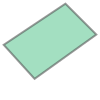

In [4]:
bbox

In [5]:
# Build a single key:tag query
query = overpass.write_query(
    bbox=bbox,
    tag="highway",
    value_constraints=["primary", "secondary", "tertiary"],
)

print(query)

[out:json][timeout:1000]; nwr["highway"~"primary|secondary|tertiary"](-27.593, 152.92, -27.52, 153.01); out geom qt;


In [6]:
# submit query, get json response
response = overpass.request_osm(query)

In [7]:
# convert json to gdf!, clip by footprint
major_roads = json_to_geometries(response)
major_roads = gpd.clip(major_roads, bbox)

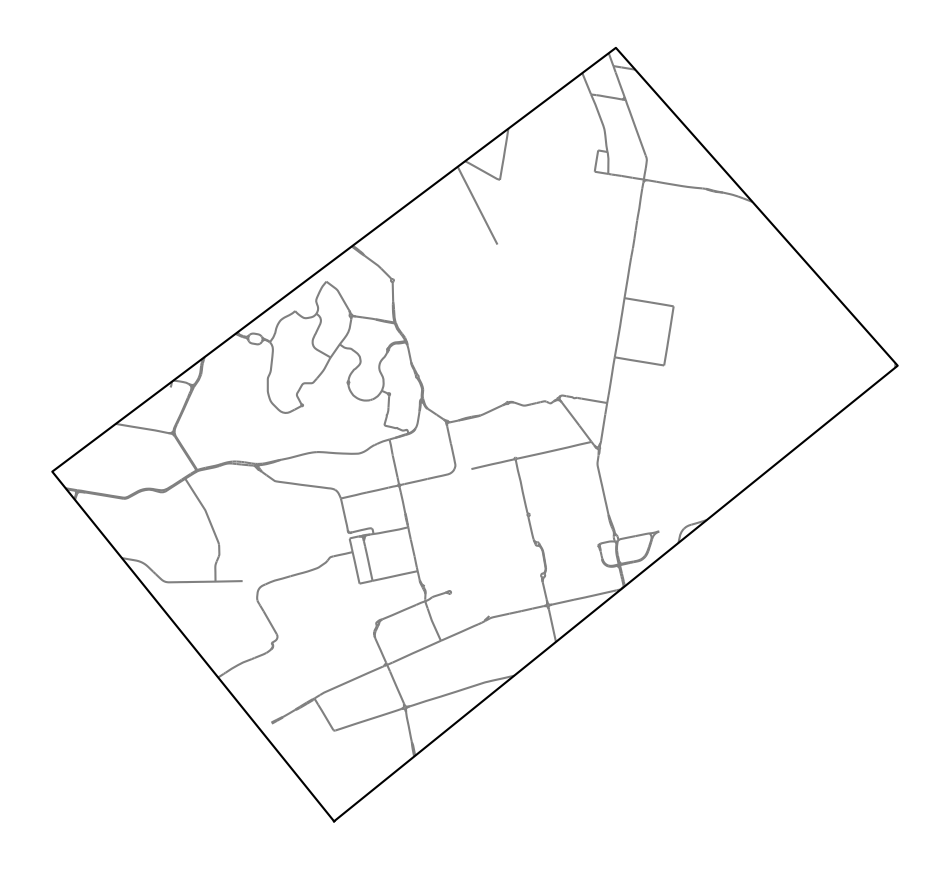

In [8]:
# Plot !!
fig, ax = plt.subplots(figsize=(12, 12))
major_roads.plot(ax=ax, label="Major Road", color="gray")
plt.plot(*bbox.exterior.xy, color="k")  #plot boundary
plt.axis("off")
plt.show()

## Grab more layers...

In [9]:
# Let's grab parks - this has some messier geometries
query = overpass.write_query(bbox=bbox, tag="leisure", value_constraints=["park"])

response = overpass.request_osm(query)
parks = json_to_geometries(response)
parks = gpd.clip(parks, bbox)

In [10]:
# Let's grab buildings too - ALL! (no constraints)
query = overpass.write_query(
    bbox=bbox,
    tag="building",
)

response = overpass.request_osm(query)
buildings = json_to_geometries(response)
buildings = gpd.clip(buildings, bbox)

In [11]:
# What if we want to grab multiple keys at once? can combine in a single query!
# for example let's find all things water
print("Water-related keys and tags:\n", WATER_TAG_RESTRICTIONS)
query = overpass.dict_to_query(bbox=bbox, tag_values_dict=WATER_TAG_RESTRICTIONS)
response = overpass.request_osm(query)
water = json_to_geometries(response)
water = gpd.clip(water, bbox)

Water-related keys and tags:
 {'landuse': ['salt_pond', 'aquaculture', 'basin', 'reservoir'], 'natural': ['water'], 'water': None, 'waterway': None}


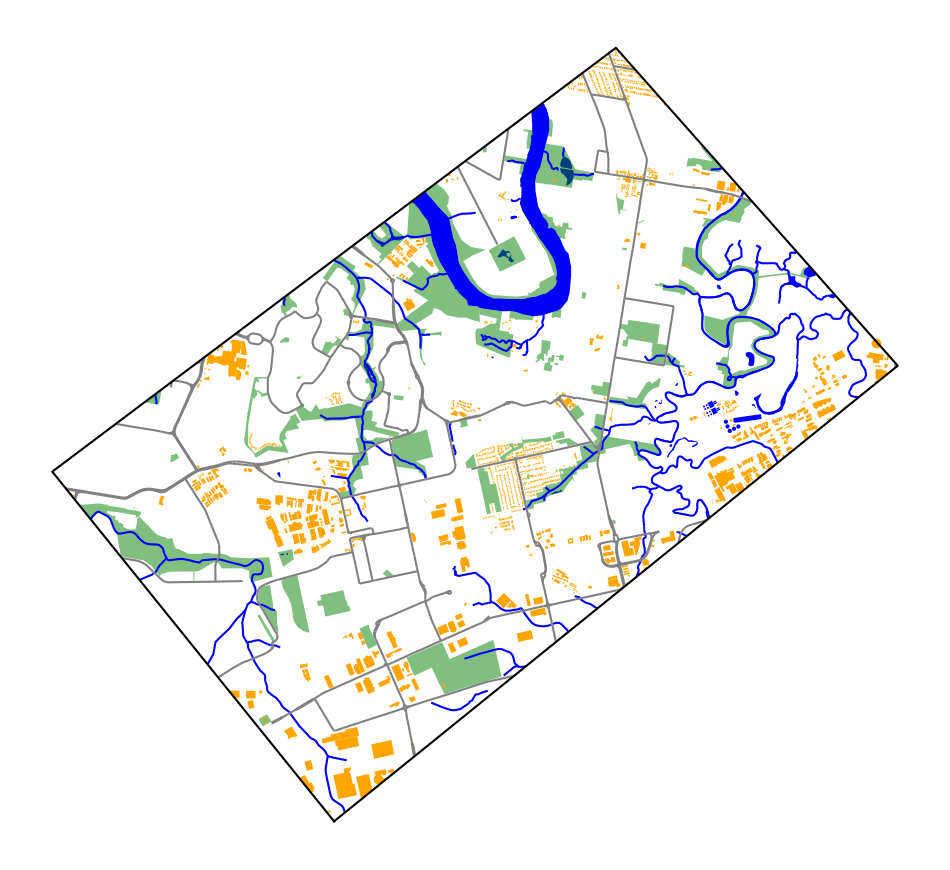

In [12]:
# Plot !!

fig, ax = plt.subplots(figsize=(12, 12))
water.plot(ax=ax, color="blue", label="Water")
parks.plot(ax=ax, color="g", label="Park", alpha=0.5)
major_roads.plot(ax=ax, label="Major Road", color="gray")
buildings.plot(ax=ax, label="Building", color="orange")
plt.plot(*bbox.exterior.xy, color="k")  #plot boundary
plt.axis("off")
plt.show()